## About
This notebook contains simple, toy examples to help you get started with FairMLHealth tool usage. This same content is mirrored in the repository's main [README](../../../README.md)

## Example Setup

In [1]:
from fairmlhealth import report, measure, stat_utils


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor

In [2]:
# First we'll create a semi-randomized dataframe with specific columns for our attributes of interest
np.random.seed(506)
N = 240
X = pd.DataFrame({'col1': np.random.randint(1, 4, N), 
                  'col2': np.random.randint(1, 75, N),
                  'col3': np.random.randint(0, 2, N),
                  'gender': [0, 1]*int(N/2), 
                  'ethnicity': [1, 1, 0, 0]*int(N/4),
                  'other': [1, 0, 0, 0, 1, 0, 0, 1]*int(N/8)
                 })

# Next we'll create a randomized target variable
y = pd.Series((X['col3']+X['gender']).values + np.random.uniform(0, 6, N), name='Example_Continuous_Target')

# Third, we'll split the data and use it to train two generic models
splits = train_test_split(X, y, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = splits

model_1 = LinearRegression().fit(X_train, y_train)
model_2 = TweedieRegressor().fit(X_train, y_train)


In [3]:
display(X.head(), y.head())

,col1,col2,col3,gender,ethnicity,other
0,1,15,0,0,1,1
1,3,51,1,1,1,0
2,1,30,1,0,0,0
3,2,28,1,1,0,0
4,1,72,0,0,1,1


0    1.700759
1    2.312593
2    6.117705
3    3.481302
4    1.051515
Name: Example_Continuous_Target, dtype: float64

## Model Measurement
fairMLHealth has tools to create generalized reports of model bias and performance.

The primary reporting tool is now the **compare** function, which can be used to generate side-by-side comparisons for any number of models, and for either binary classifcation or for regression problems. Model performance metrics such as accuracy and precision (or MAE and RSquared for regression problems) are also provided to facilitate comparison. Below is an example output comparing the two example models defined above. Missing values have been added for metrics requiring prediction probabilities (which the second model does not have).

A flagging protocol is applied by default to highlight any cells with values that are out of range.  This can be turned off by passing ***flag_oor = False*** to report.compare().

In [4]:
# Generate a measure report
report.compare(X_test, y_test,  X_test['gender'],  model_1,  pred_type="regression")


In [6]:
report.compare(X_test, y_test,  X_test['gender'],  model_1,
                             pred_type="regression", flag_oor=False, skip_performance=True)


model 1
Metric              Measure                                    
Group Fairness      Mean Prediction Ratio                0.7721
                    MAE Ratio                            1.2864
                    Mean Prediction Difference          -1.0663
                    MAE Difference                       0.3878
Individual Fairness Consistency Score                    0.3652
                    Between-Group Gen. Entropy Error     0.0000
Data Metrics        Prevalence of Privileged Class (%)   0.0000

In [5]:
from IPython.core.display import HTML
html_output = report.compare(X_test, y_test,  X_test['gender'],  model_1,  pred_type="regression", output_type="html")
HTML(html_output)

## Evaluation

FairMLHealth now also includes stratified table features to aid in identifying the source of unfairness or other bias: data tables, performance tables, and bias tables. Note that these stratified tables can evaluate multiple features at once, and that there are two options for identifying which features to assess.

Note that the flag tool has not yet been updated to work with stratified tables.

### Significance Testing

It's recommended to test for the statistical significance of discrepancies in the distribution of results. This is particularly true for attributes with skewed distributions, for which small sample sizes for less common labels may affect fairness measures. However it is still generally recommended to validate whether the test sample for which fairness measures are generated is reflective of the full dataset.

FairMLHealth comes with a bootstrapping utility and supporting funcitons that can be used in some statistical testing. While the selection of proper statistical tests is beyond the scope of this notebooks, two examples using the bootstrap_significance tool with built-in test functions are shown below.

In [7]:
isMale = X['gender'].eq(1)
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              dist_a=y.loc[isMale], 
                                              dist_b=y.loc[~isMale])
print("Is it likely that the difference in the mean y value is related to gender?\n", reject_h0)

Is it likely that the difference in the mean y value is related to gender?
 False


In [8]:
isCaucasian = X['ethnicity'].eq(1)
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              dist_a=y.loc[isCaucasian], 
                                              dist_b=y.loc[~isCaucasian])
print("Is it likely that the difference in the mean y value is related to ethnicity?\n", reject_h0)

Is it likely that the difference in the mean y value is related to ethnicity?
 False


### Stratified Data Tables

The data table is shown below with each of the two data argument options. It evaluates basic statistics specific to each feature-value, in addition to relative statistics for the target value. Since the table can be used to evaluate many features at once, it can be a useful option for identifying patterns of bias either alone or in concert with other (e.g., visual methods).

In [9]:
# Arguments Option 1: pass full set of data, subsetting with *features* argument
measure.data(X_test, y_test, features=['gender'])

,Feature Name,Feature Value,Obs.,Entropy,Mean Example_Continuous_Target,Median Example_Continuous_Target,Missing Values,Std. Dev. Example_Continuous_Target,Value Prevalence
0,ALL FEATURES,ALL VALUES,120,NaN,4.2513,4.5745,0,1.9809,1.0000
1,gender,0,62,0.9992,3.5410,3.7835,0,2.0357,0.5167
2,gender,1,58,0.9992,5.0106,5.0673,0,1.6192,0.4833


### Stratified Performance Tables

The stratified performance table can be used to evaluate model performance specific to each feature-value subset.

In [10]:
measure.performance(X_test[['gender']], y_test, 
                           model_1.predict(X_test), pred_type="regression")

,Feature Name,Feature Value,Obs.,Mean Target,Mean Prediction,MAE,MSE,Mean Error,Rsqrd,Std. Dev. Error,Std. Dev. Prediction,Std. Dev. Target
0,ALL FEATURES,ALL VALUES,120.0,4.2513,4.1290,1.5547,3.3753,-0.1224,0.1326,1.8408,0.9631,1.9809
1,gender,0,62.0,3.5410,3.6136,1.7422,3.8787,0.0725,0.0487,1.9842,0.7671,2.0357
2,gender,1,58.0,5.0106,4.6799,1.3544,2.8372,-0.3307,-0.1012,1.6660,0.8420,1.6192


### Stratified Bias Tables

The stratified bias table presents model bias specific to each feature-value subset. Inspired by common measures of fairness, the table generator assumes each feature-value as the "privileged" group relative to all other possible values for the feature. For example, row 3 in the table below displaying measures of "col1" value of "2" where 2 is considered to be the privileged group and all other values (1, 2, 45, and 50) are considered unprivileged.

To simplify the table, fairness measures have been reduced to their component parts. For example, measures of Equalized Odds can be determined by combining the True Positive Rate (TPR) Ratios & Differences with False Positive Rate (FPR) Ratios & Differences.

See also: [Fairness Quick References](../docs/Fairness_Quick_References.pdf) and the [Tutorial for Evaluating Fairness in Binary Classification](./Tutorial-EvaluatingFairnessInBinaryClassification.ipynb)

In [11]:
measure.bias(X_test[['gender', 'col1']], 
             y_test, 
             model_1.predict(X_test), 
             pred_type="regression",
            flag_oor=True,
            custom_ranges={'MAE Difference':(-0.1, 0.1), 'mean prediction difference':(-2,2)})

,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
0,gender,0,-0.3878,0.7774,1.0663,1.2951
1,gender,1,0.3878,1.2864,-1.0663,0.7721
2,col1,1,-0.2275,0.8650,0.1545,1.0382
3,col1,2,0.2495,1.1816,0.1337,1.0332
4,col1,3,0.0279,1.0182,-0.3067,0.9294


In [12]:
measure.summary(X_test[['gender', 'col1']], 
             y_test, 
             model_1.predict(X_test),
                prtc_attr=X_test['gender'], 
             pred_type="regression",
            flag_oor=True,
            custom_ranges={ 'mean prediction difference':(-0.5,2)})

## Comparing Results for Multiple Models

The **compare** feature can be used to generate side-by-side fairness comparisons of multiple models or multiple protected attributes. Model performance metrics such as accuracy and precision are also provided to facilitate comparison.   

Below is an example output comparing the two example models defined above. Missing values have been added for metrics requiring prediction probabilities, which the second model does not have (note the warning below).

In [13]:
# Generate a pandas dataframe of measures
report.compare(X_test,  y_test,  X_test['gender'], {'model 1':model_1, 'model 2':model_2}, pred_type="regression")


## Special Cases

### Hypothetical Example for which Only Mid-Range Values Need Be Accurate

Patients undergoing a multi-stage surgical procedure, the treatment times for which are predicted by a machine learning model.

| Average Predicted Time in Surgery | Intervention |
| - | - |
|0-5 hours | Outpatient Procedures |
|5-9 hours | Treatment Decision Depends on Predicted Trends in Surgery Time |
| 9+ hours | Inpatient Procedures |

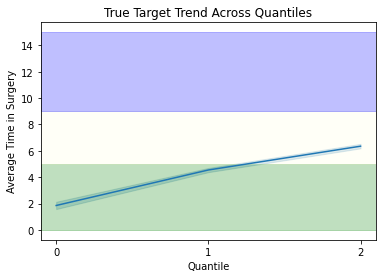

In [14]:
# Generate quantiles
quantiles = pd.qcut(y_test, 3, labels=False).rename('quantile')

# Generate plots
g = sns.lineplot(x=quantiles, y=y_test)
g.axhspan(0, 5, alpha=0.25, color='green')
g.axhspan(5, 9, alpha=0.25, color='lightyellow')
g.axhspan(9, 15, alpha=0.25, color='blue')
plt.xticks([*range(3)], [*range(3)])
g.set_xlabel("Quantile")
g.set_ylabel("Average Time in Surgery")
g.set_title("True Target Trend Across Quantiles")
plt.show()


## Analysis by Cohort

Table-generating functions in the **measure** module can all be additionally grouped using the *cohorts* argument to specify additional labels for each observation. Cohorts may consist of either a single label or a set of labels, and may be either separate from or attached to the existing data.

In [15]:
# Separate, Single-Level Cohorts
measure.bias(X_test['gender'], y_test, model_1.predict(X_test), 
             pred_type="regression", cohorts=quantiles.rename("cohort"))

,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
cohort,,,,,,
0,gender,0,0.2528,1.1367,0.9248,1.2671
0,gender,1,-0.2528,0.8797,-0.9248,0.7892
1,gender,0,-0.5586,0.5442,1.0694,1.2992
1,gender,1,0.5586,1.8377,-1.0694,0.7697
2,gender,0,-0.4268,0.7982,0.8692,1.2194
2,gender,1,0.4268,1.2528,-0.8692,0.8200


In [16]:
## Multi-Level Cohorts for the Data table
measure.data(X=X_test[['col3']], Y=y_test, cohorts=X_test[['gender', 'ethnicity']])

Feature Name Feature Value  Obs.  Entropy  \
gender ethnicity                                              
0      0          ALL FEATURES    ALL VALUES    29      NaN   
       0                  col3             0    15   0.9991   
       0                  col3             1    14   0.9991   
       1          ALL FEATURES    ALL VALUES    33      NaN   
       1                  col3             0    18   0.9940   
       1                  col3             1    15   0.9940   
1      0          ALL FEATURES    ALL VALUES    26      NaN   
       0                  col3             0    11   0.9829   
       0                  col3             1    15   0.9829   
       1          ALL FEATURES    ALL VALUES    32      NaN   
       1                  col3             0    12   0.9544   
       1                  col3             1    20   0.9544   

                  Mean Example_Continuous_Target  \
gender ethnicity                                   
0      0                                  3.9273   
       0                                  3.3797   
       0                                  4.5141   
       1                                  3.2016   
       1                                  2.4920   
       1                                  4.0530   
1      0                                  4.9544   
       0                                  4.6557   
       0                                  5.1735   
       1                                  5.0563   
       1                                  4.2436   
       1                                  5.5440   

                  Median Example_Continuous_Target  Missing Values  \
gender ethnicity                                                     
0      0                                    3.9847               0   
       0                                    3.7754               0   
       0                                    4.4485               0   
       1                                    2.6024               0   
       1                                    1.6709               0   
       1                                    5.1426               0   
1      0                                    4.7895               0   
       0                                    4.5711               0   
       0                                    5.0948               0   
       1                                    5.2957               0   
       1                                    4.2397               0   
       1                                    5.6740               0   

                  Std. Dev. Example_Continuous_Target  Value Prevalence  
gender ethnicity                                                         
0      0                                       1.9164            1.0000  
       0                                       1.9532            0.5172  
       0                                       1.7564            0.4828  
       1                                       2.1053            1.0000  
       1                                       1.8859            0.5455  
       1                                       2.0949            0.4545  
1      0                                       1.4701            1.0000  
       0                                       1.6014            0.4231  
       0                                       1.3805            0.5769  
       1                                       1.7530            1.0000  
       1                                       1.7731            0.3750  
       1                                       1.5894            0.6250